In [1]:
import os
print(len(os.listdir("./all_images")))

4000


In [2]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img

Using TensorFlow backend.


In [3]:
IMAGE_WIDTH = 80 # Lo indica en kaggle
IMAGE_HEIGHT = 80 # Lo indica en kaggle
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3 # Lo indica en kaggle, RGB

In [4]:
nombrearchivo = os.listdir("./all_images/")
categoria = []
for i in nombrearchivo:
    if '1' in i[0]:
        categoria.append(1)
    else:
        categoria.append(0)

fulldata = pd.DataFrame({'nombre_archivo': nombrearchivo, 'category': categoria})
fulldata['category'] = fulldata['category'].astype('str')

fulldata.head(10)

nombre_archivo category
0  0__20170713_180938_1002__-122.11497923392102_3...        0
1  0__20170903_181304_1041__-122.3482784305868_37...        0
2  0__20170713_180940_1002__-122.3221021529008_37...        0
3  0__20170905_181214_0f12__-122.35609416372331_3...        0
4  0__20160905_193458_0c37__-122.340008531414_37....        0
5  0__20161018_192144_0c24__-122.36068782806099_3...        0
6  0__20160905_193458_0c37__-122.46381277841687_3...        0
7  0__20170724_181036_1011__-122.3396918637242_37...        0
8  0__20170716_180833_101b__-122.40700928865517_3...        0
9  1__20180710_180333_1002__-118.1615201605814_33...        1

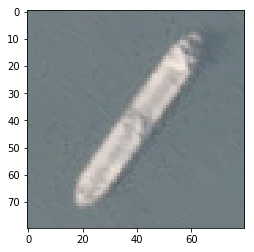

In [7]:
# Ploteamos una imagen de ejemplo de nuestro dataset
ejemplo = random.choice(nombrearchivo)
imagen = load_img("./all_images/"+ejemplo)
plt.imshow(imagen)

# Convolutional

In [8]:
# Definimos nuestro modelo convolucional

from keras.models import Sequential
from keras.layers import Convolution2D, SeparableConvolution2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras_metrics

# Early Stopping limita el sobre entrenamiento, indicando una cantidad de epocas
# para que frene si el valor de perdida no disminuye.
# ReduceLROnPlateau reduce el learning rate si f1-Score no aumenta luego de x iteraciones.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
"""border_mode='same',"""
model_conv = Sequential([
    Convolution2D(32, (3, 3), border_mode='same', activation='relu', 
           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Convolution2D(64, (3, 3), border_mode='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Convolution2D(128, (3, 3), border_mode='same', activation='relu'),
    BatchNormalization(),
    SeparableConvolution2D(32, (3, 3), border_mode='same', activation='tanh'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

model_conv.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[keras_metrics.precision(), keras_metrics.recall(), keras_metrics.f1_score()])

# Mostramos por pantalla el resumen del modelo
model_conv.summary()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(80, 80, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (3, 3), activation="tanh", padding="same")`


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 40, 64)        256       
___________________________

In [9]:
# https://keras.io/callbacks/

# Seteamos los valores indicados arriba
# patience: number of epochs with no improvement after which training will be stopped.
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_f1_score', # quantity to be monitored.
                                            patience=2, # number of epochs with no improvement after which learning rate will be reduced.
                                            verbose=1, # update messages.
                                            factor=0.5, # factor by which the learning rate will be reduced. new_lr = lr * factor
                                            min_lr=0.00001) # lower bound on the learning rate.

callbacks = [earlystop, learning_rate_reduction]

In [10]:
# Dividimos nuestro set de datos en Train, Test y Validation para el modelo convolucional
train_fulldata, no_train = train_test_split(fulldata, test_size=0.4, random_state=42)
test_fulldata, validation_fulldata = train_test_split(no_train, test_size=0.5, random_state=42)
train_fulldata = train_fulldata.reset_index(drop=True)
test_fulldata = test_fulldata.reset_index(drop=True)
validation_fulldata = test_fulldata.reset_index(drop=True)

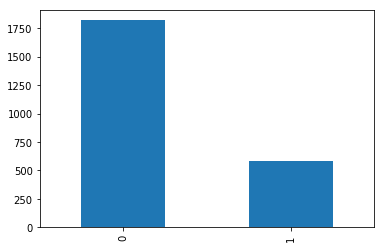

In [11]:
""" 
Vemos que tenemos un dataset desbalanceado, por lo tanto usar accuracy no sería lo
adecuado. En base a esto nos pareció mejor utilizar f1-score, mostrando también los
valores de precission y recall para poder observar cuál es el que falla.
"""

train_fulldata['category'].value_counts().plot.bar()

In [12]:
total_train = train_fulldata.shape[0] # asigna la cantidad de registros de la matriz
total_test = test_fulldata.shape[0] # asigna la cantidad de registros de la matriz
total_validation = validation_fulldata.shape[0] # asigna la cantidad de registros de la matriz
batch_size=15

In [13]:
# Train generator parte 1

"""ImageDataGenerator: generate batches of tensor image data with real-time data augmentation. 
The data will be looped over (in batches)
https://keras.io/preprocessing/image/"""

train_datagen = ImageDataGenerator(
    #Degree range for random rotations.
    rotation_range=15,
    # We multiply the data by the value provided (after applying all other transformations).
    rescale=1./255,
    # Shear Intensity (Shear angle in counter-clockwise direction in degrees).
    shear_range=0.1,
    #  Randomly flip inputs horizontally.
    horizontal_flip=True
)

In [14]:
# Train generator parte 2

"""flow_from_dataframe:
Takes the dataframe and the path to a directory and generates batches of
augmented/normalized data.

Return:
A DataFrameIterator yielding tuples of (x, y) where x is a numpy array containing a batch
of images with shape (batch_size, *target_size, channels) and y is a numpy array of 
corresponding labels.
"""
train_generator = train_datagen.flow_from_dataframe(
    # Pandas DataFrame which contains the filenames and classes or numeric data to be treated as target values.
    train_fulldata, 
    # Path to the folder which contains all the images.
    "./all_images/", 
    # The column in the dataframe that has the filenames of the images.
    x_col='nombre_archivo',
    # Column in dataframe that has the target data.
    y_col='category',
    # The dimensions to which all images found will be resized.
    target_size=IMAGE_SIZE,
    # Mode for yielding the targets.
    class_mode='binary',
    # Size of the batches of data.
    batch_size=batch_size
)

Found 2400 images belonging to 2 classes.


In [15]:
# Test generator
# Hacemos casi lo mismo que hacemos para train pero sin generar nuevas imagenes

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_fulldata, 
    "./all_images/", 
    x_col='nombre_archivo',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 800 images belonging to 2 classes.


In [20]:
# Un ejemplo de lo que hacemos en el train generator

example_df = train_fulldata.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./all_images/", 
    x_col='nombre_archivo',
    y_col='category',
    target_size=IMAGE_SIZE,
)

Found 1 images belonging to 1 classes.


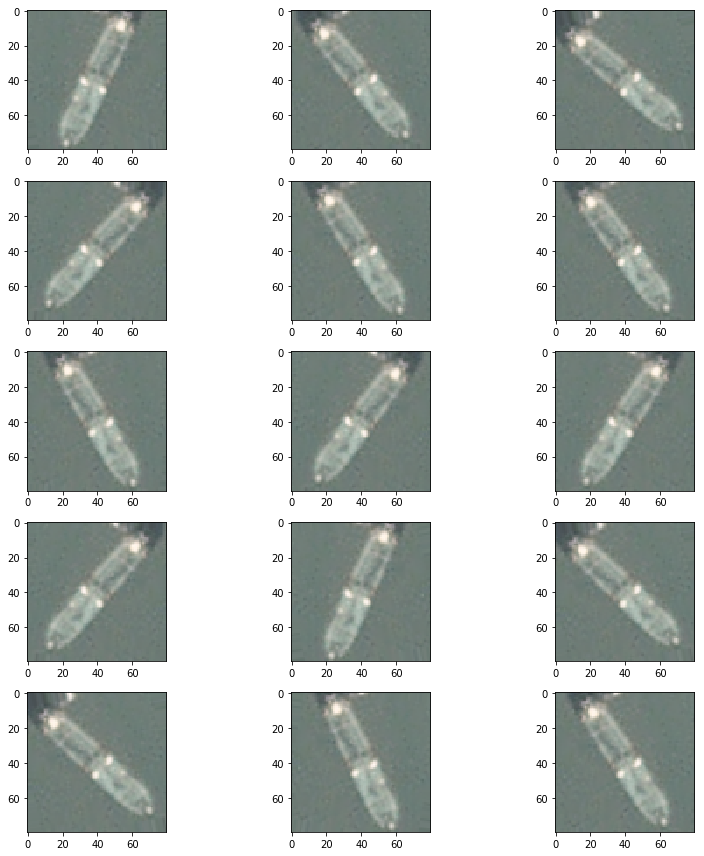

In [21]:
# Ploteamos las figuras generadas arriba
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [22]:
# Entrenamos nuestro modelo
epochs=20
history = model_conv.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=total_test//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
160/160 [==============================] - 46s 288ms/step - loss: 0.4216 - precision: 0.6245 - recall: 0.7887 - f1_score: 0.6970 - val_loss: 0.1837 - val_precision: 0.9148 - val_recall: 0.7854 - val_f1_score: 0.8451
Epoch 2/20
160/160 [==============================] - 41s 258ms/step - loss: 0.2254 - precision: 0.8143 - recall: 0.8213 - f1_score: 0.8178 - val_loss: 0.3077 - val_precision: 0.9125 - val_recall: 0.7157 - val_f1_score: 0.8022
Epoch 3/20
160/160 [==============================] - 42s 261ms/step - loss: 0.1713 - precision: 0.8741 - recall: 0.8711 - f1_score: 0.8726 - val_loss: 0.2336 - val_precision: 0.9086 - val_recall: 0.7794 - val_f1_score: 0.8391
Epoch 4/20
160/160 [==============================] - 41s 254ms/step - loss: 0.1364 - precision: 0.8924 - recall: 0.8832 - f1_score: 0.8877 - val_loss: 0.4936 - val_precision: 0.9483 - val_recall: 0.5556 - val_f1_score: 0.7006
Epoch 5/20
160/160 [========================

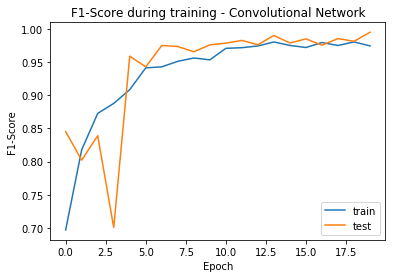

In [23]:
plt.plot(history.history['f1_score'], label='train')
plt.plot(history.history['val_f1_score'], label='test')
plt.title('F1-Score during training - Convolutional Network')
plt.ylabel('F1-Score')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

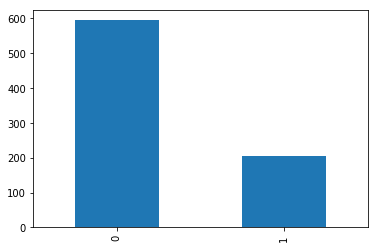

In [24]:
# Corroboramos la cantidad de Barcos/NoBarcos que teniamos en VALIDATION
# Antes de borrar la columna para pasarsela al modelo para que prediga
validation_fulldata['category'].value_counts().plot.bar()

In [25]:
# validation generator (Lo mismo que para los otros dos, salvo que no le pasamos el target)

# Eliminamos la categoría del Dataframe
validation_fulldata = validation_fulldata.drop(['category'],axis=1)

validation_gen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_gen.flow_from_dataframe(
    validation_fulldata, 
    "./all_images/", 
    x_col='nombre_archivo',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 800 images.


In [27]:
# Predecimos el modelo y guardamos en una variable para agregar al Dataframe y así
# poder mostrar la imagen con el resultado
predict = model_conv.predict_generator(validation_generator, steps=np.ceil(total_validation/batch_size))

In [28]:
# en categ marcamos como barco todo lo que predict lo catalogue como > 95% de F1
threshold = 0.95
validation_fulldata['probability'] = predict
validation_fulldata['categ'] = np.where(validation_fulldata['probability'] > threshold, 1,0)

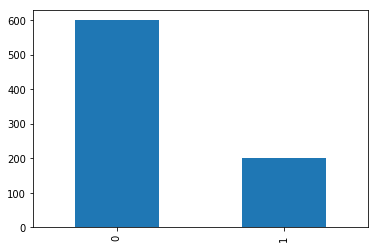

In [29]:
# Vemos si los numeros se acercan a lo original que habia en validation
validation_fulldata['categ'].value_counts().plot.bar()

### Muestra de algunas de las predicciones del modelo convolucional

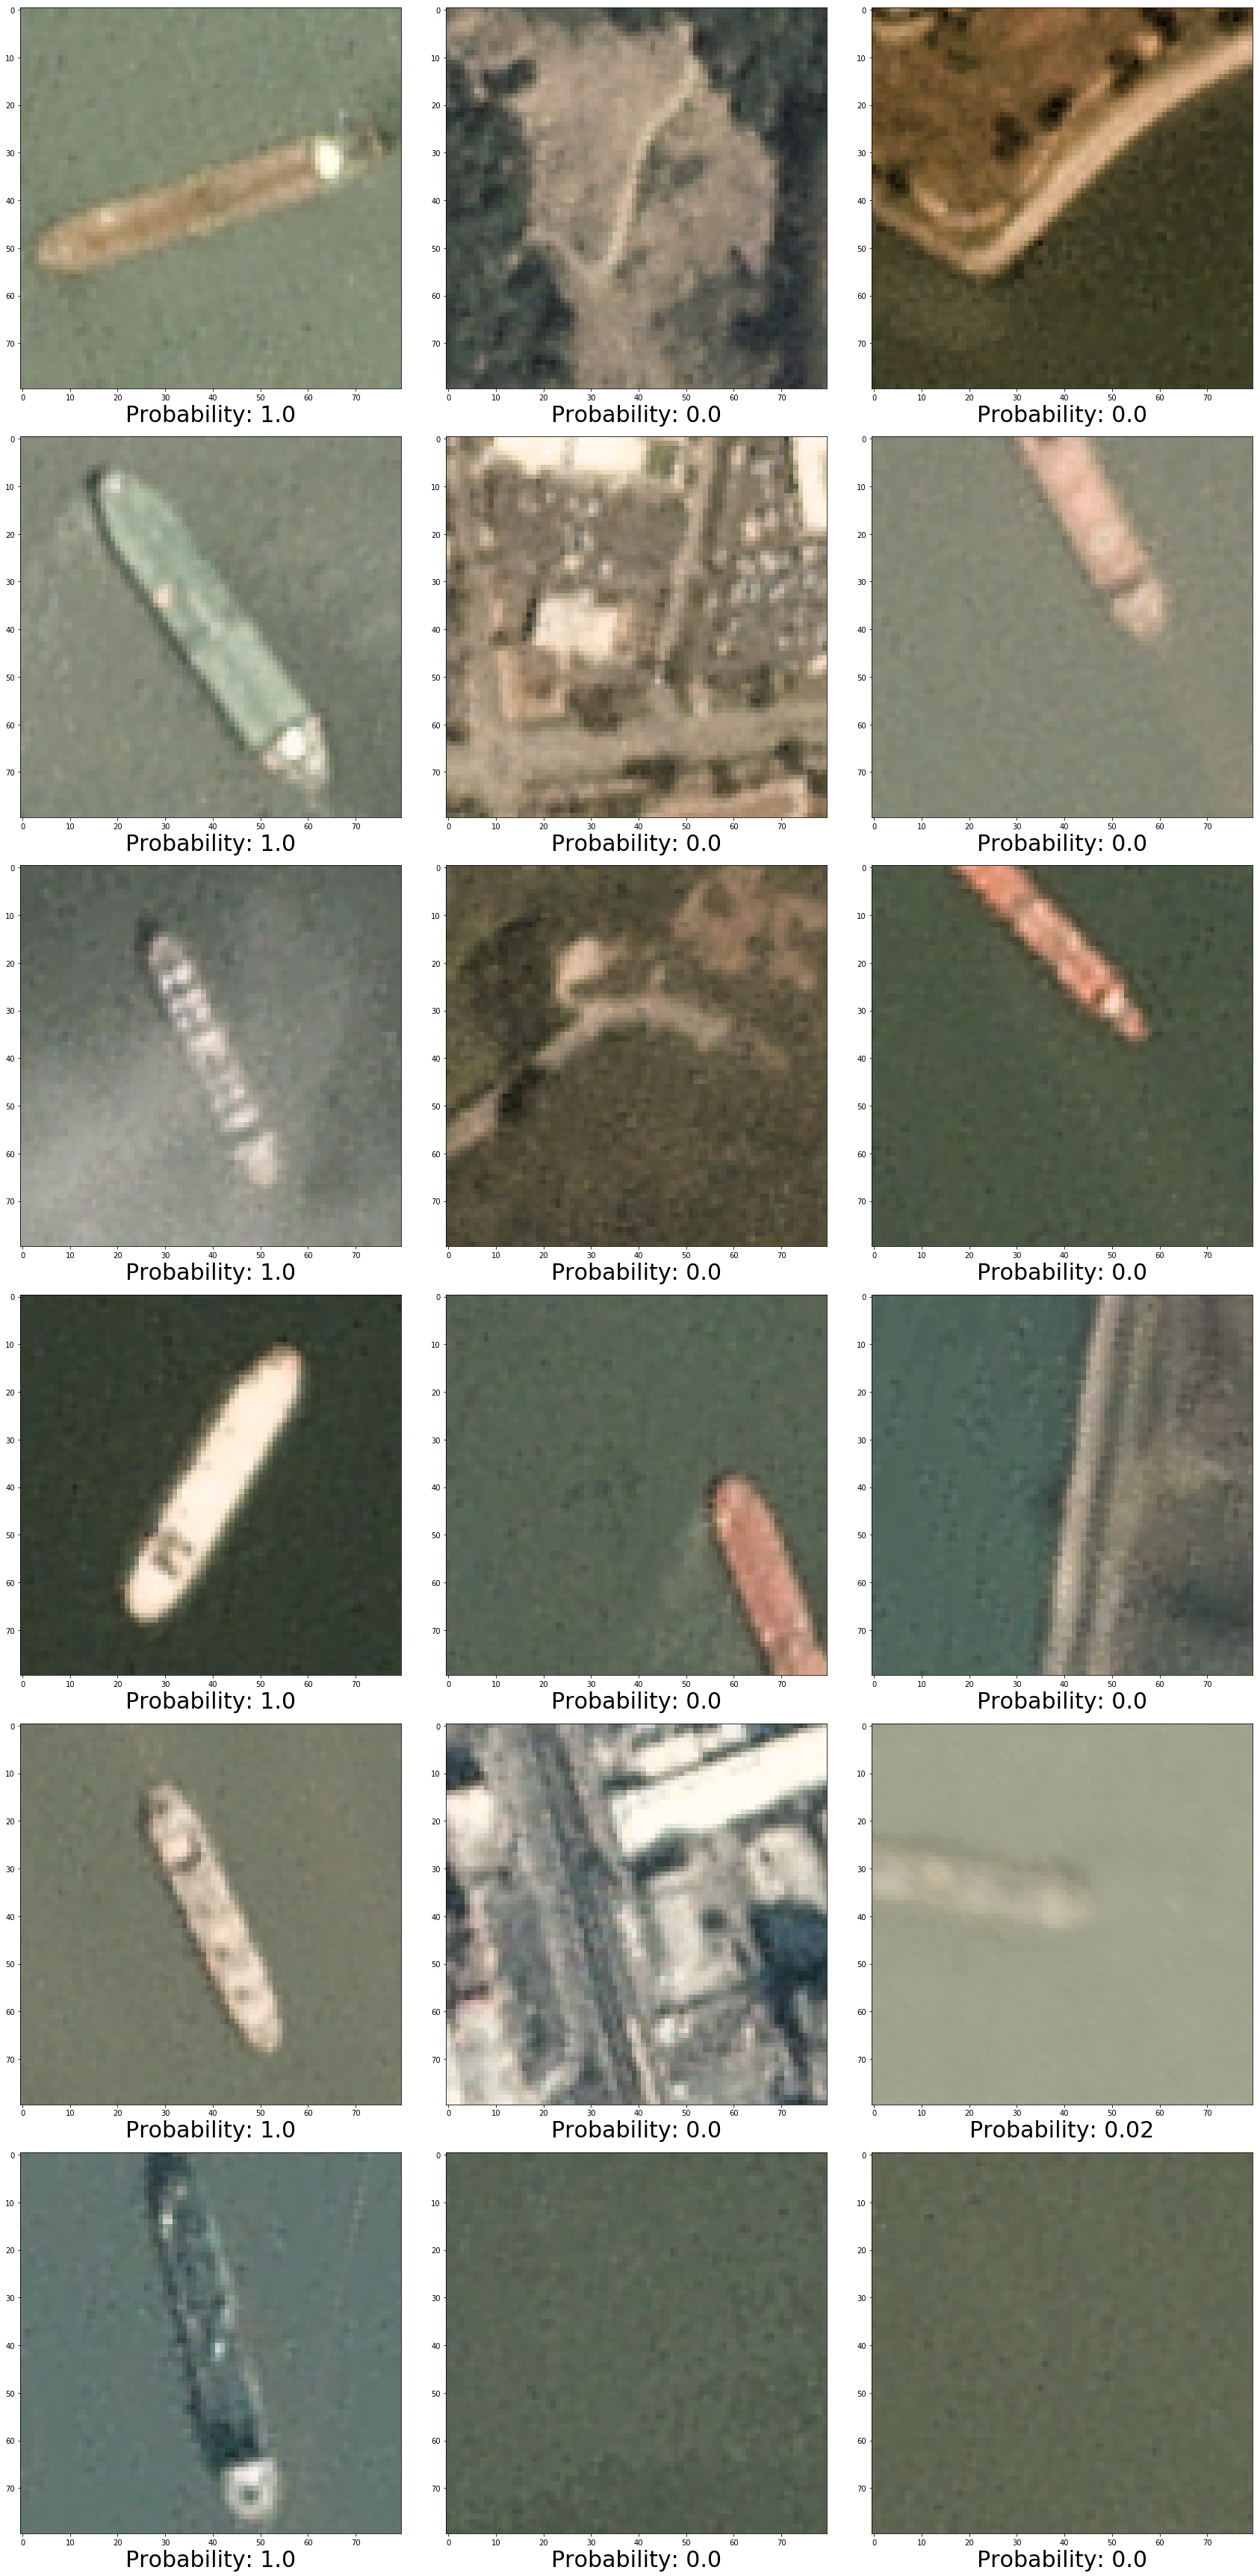

In [30]:
ejemplos = validation_fulldata.head(18)
plt.figure(figsize=(24, 48))
for index, row in ejemplos.iterrows():
    filename = row['nombre_archivo']
    category = row['categ']
    probability = row['probability']
    img = load_img("./all_images/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel('Probability: ' + str(round(probability, 2)), fontsize=30)

plt.tight_layout()
plt.show()

# MLP

In [31]:
#MLP
mlp_model = Sequential([   
    Dense(300, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
    Activation('tanh'),
    Flatten(),
    Dropout(0.1),
    Dense(200),
    Activation('relu'),
    Dropout(0.1),
    Dense(100),
    Activation('tanh'),
    Dense(1),
    Activation('sigmoid'),
])

mlp_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[keras_metrics.precision(), keras_metrics.recall(), keras_metrics.f1_score()])

mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 80, 80, 300)       1200      
_________________________________________________________________
activation_1 (Activation)    (None, 80, 80, 300)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920000)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1920000)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               384000200 
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
__________

In [32]:
# Dividimos nuestro set de datos en Train, Test y Validation para MLP
mlp_train_fulldata, mlp_no_train = train_test_split(fulldata, test_size=0.4, random_state=42)
mlp_test_fulldata, mlp_validation_fulldata = train_test_split(mlp_no_train, test_size=0.5, random_state=42)
mlp_train_fulldata = mlp_train_fulldata.reset_index(drop=True)
mlp_test_fulldata = mlp_test_fulldata.reset_index(drop=True)
mlp_validation_fulldata = mlp_test_fulldata.reset_index(drop=True)

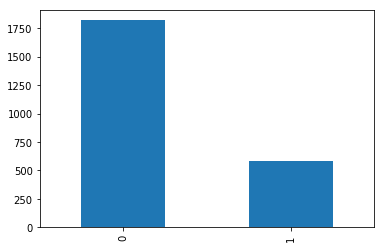

In [33]:
""" 
Vemos que tenemos un dataset desbalanceado, por lo tanto usar accuracy no sería lo
adecuado. En base a esto nos pareció mejor utilizar f1-score, mostrando también los
valores de precission y recall para poder observar cuál es el que falla.
"""

mlp_train_fulldata['category'].value_counts().plot.bar()

In [34]:
mlp_total_train = mlp_train_fulldata.shape[0] # asigna la cantidad de registros de la matriz
mlp_total_test = mlp_test_fulldata.shape[0] # asigna la cantidad de registros de la matriz
mlp_total_validation = mlp_validation_fulldata.shape[0] # asigna la cantidad de registros de la matriz
mlp_batch_size=15

In [35]:
# Generators para modelo MLP
mlp_train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    horizontal_flip=True
)

mlp_train_generator = mlp_train_datagen.flow_from_dataframe(
    mlp_train_fulldata, 
    "./all_images/", 
    x_col='nombre_archivo',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=mlp_batch_size
)

mlp_test_datagen = ImageDataGenerator(rescale=1./255)
mlp_test_generator = mlp_test_datagen.flow_from_dataframe(
    mlp_test_fulldata, 
    "./all_images/", 
    x_col='nombre_archivo',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=mlp_batch_size
)

Found 2400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [36]:
mlp_epochs=10
mlp_history = mlp_model.fit_generator(
    mlp_train_generator, 
    epochs=mlp_epochs,
    validation_data=mlp_test_generator,
    validation_steps=mlp_total_test//mlp_batch_size,
    steps_per_epoch=mlp_total_train//mlp_batch_size
)

Epoch 1/10
160/160 [==============================] - 575s 4s/step - loss: 0.6495 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6060 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/10
160/160 [==============================] - 530s 3s/step - loss: 0.5700 - precision: 0.2727 - recall: 0.0052 - f1_score: 0.0101 - val_loss: 0.5761 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/10
160/160 [==============================] - 532s 3s/step - loss: 0.5663 - precision: 0.4286 - recall: 0.0052 - f1_score: 0.0102 - val_loss: 0.5764 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/10
160/160 [==============================] - 529s 3s/step - loss: 0.5649 - precision: 0.3333 - recall: 0.0017 - f1_score: 0.0034 - val_loss: 0.5664 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 5/10
160/160 [====================

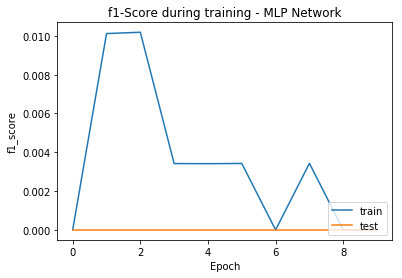

In [37]:
plt.plot(mlp_history.history['f1_score'], label='train')
plt.plot(mlp_history.history['val_f1_score'], label='test')
plt.title('f1-Score during training - MLP Network')
plt.ylabel('f1_score')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

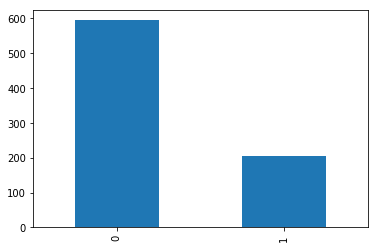

In [38]:
# Corroboramos la cantidad de Barcos/NoBarcos que teniamos en VALIDATION de MLP
# Antes de borrar la columna para pasarsela al modelo para que prediga
mlp_validation_fulldata['category'].value_counts().plot.bar()

In [39]:
# MLP Validation

# Eliminamos la categoría del Dataframe
mlp_validation_fulldata = mlp_validation_fulldata.drop(['category'],axis=1)

mlp_validation_gen = ImageDataGenerator(rescale=1./255)
mlp_validation_generator = mlp_validation_gen.flow_from_dataframe(
    mlp_validation_fulldata, 
    "./all_images/", 
    x_col='nombre_archivo',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 800 images.


In [40]:
# Predecimos con el modelo MLP
# poder mostrar la imagen con el resultado
mlp_predict = mlp_model.predict_generator(mlp_validation_generator, steps=np.ceil(mlp_total_validation/mlp_batch_size))

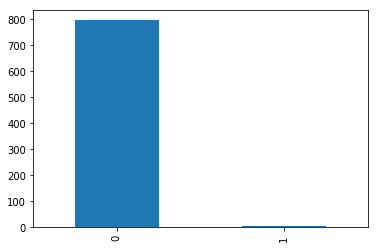

In [41]:
"""
En categ marcamos como barco todo lo que predict lo catalogue como > 20% de F1
por los valores que obtuvimos en train decidimos bajar el valor para corroborar que 
ni con ese porcentaje se acerca en las predicciones
"""
mlp_threshold = 0.2
mlp_validation_fulldata['probability'] = mlp_predict
mlp_validation_fulldata['categ'] = np.where(mlp_validation_fulldata['probability'] > mlp_threshold, 1,0)
# Vemos si los numeros se acercan a lo original que habia en validation
mlp_validation_fulldata['categ'].value_counts().plot.bar()

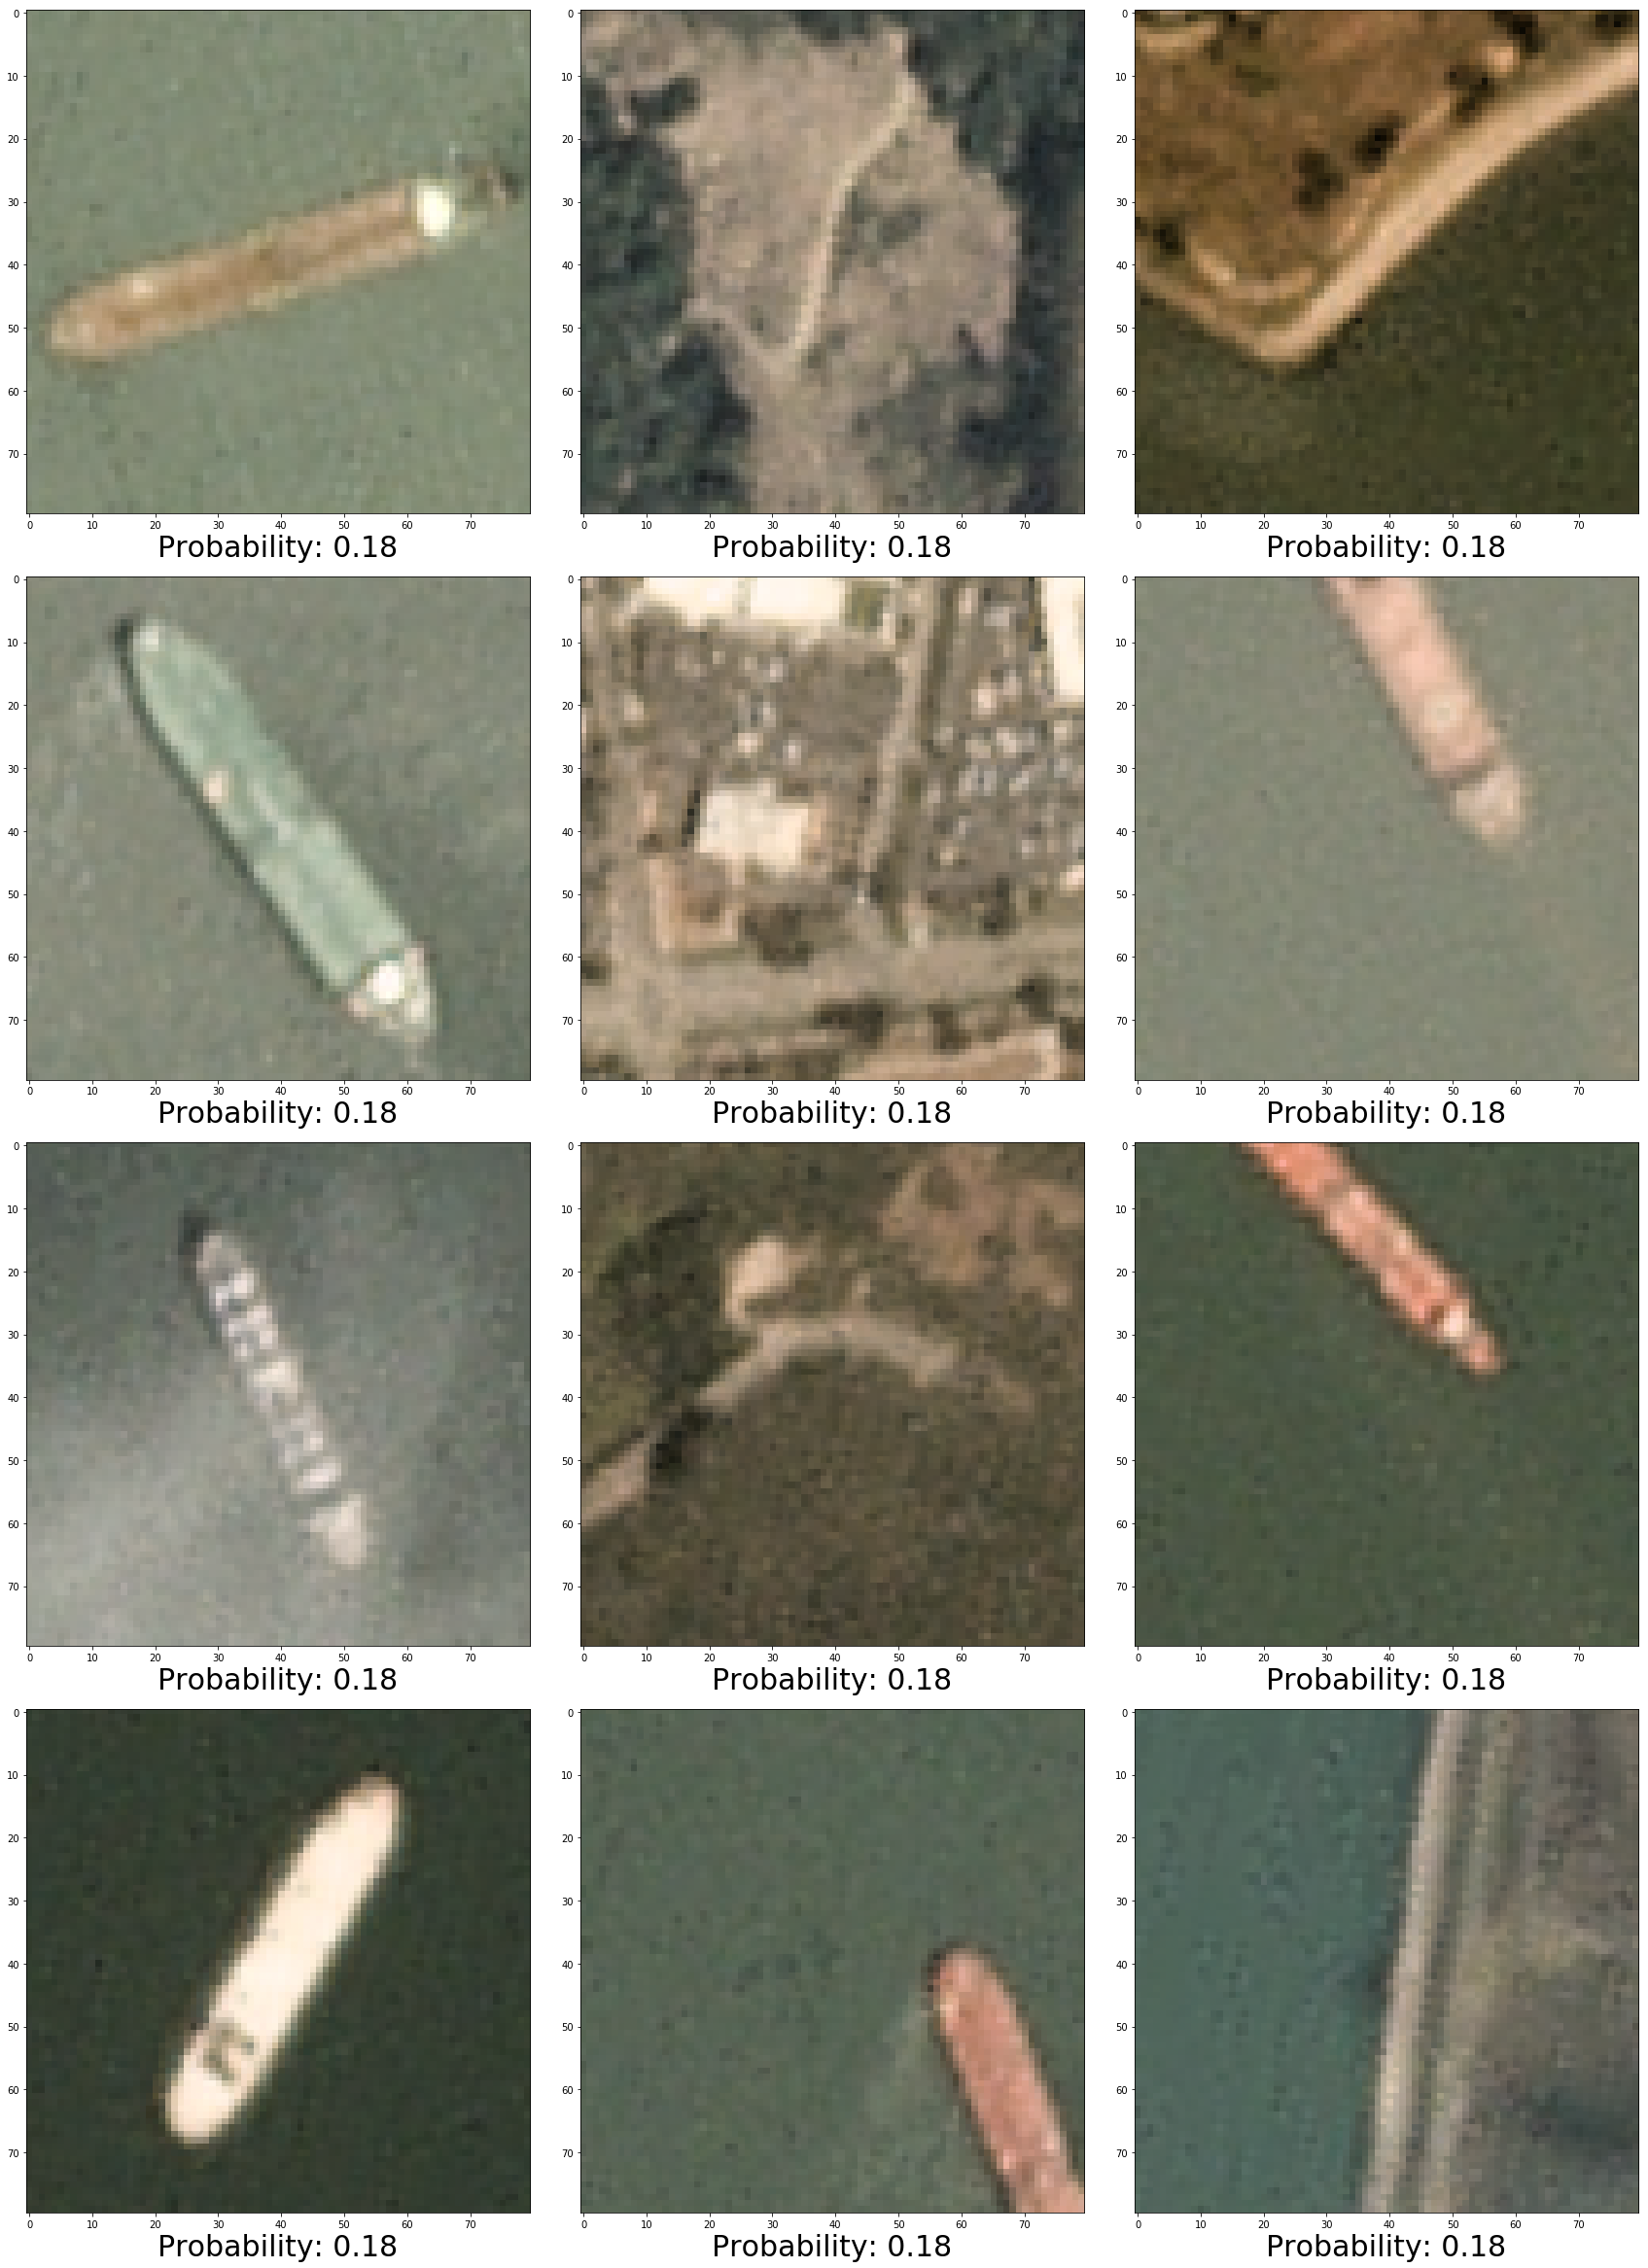

In [42]:
mlp_ejemplos = mlp_validation_fulldata.head(12)
plt.figure(figsize=(24, 48))
for index, row in mlp_ejemplos.iterrows():
    filename = row['nombre_archivo']
    category = row['categ']
    probability = row['probability']
    img = load_img("./all_images/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel('Probability: ' + str(round(probability, 2)), fontsize=30)

plt.tight_layout()
plt.show()

# Conclusiones de la entrega 3

A partir de los gráficos se puede apreciar a simple vista el éxito de la red convolucional frente al fracaso de la MLP.
Esto marca claramente lo que se nos dijo en clase, para reconocimiento por imagenes las redes convolucionales están por encima de cualquier otra en este tema.

Como marcamos en los comentarios la métrica utilizada fue F1-Score, debido a que teníamos un dataset desbalanceado y esto nos imposibilitaba el uso de Accuracy.

La red convolucional desde la época 10 predice a un valor superior del 97% sin overfitear ya que los resultados son los mismos en test y validation, lo que demuestra la eficiencia de la misma, mientras que la MLP a ese nivel ni siquiera supera el 10%. 

Creemos que al generar más imagenes, rotadas, en diferentes posiciciones, le otorgamos más ayuda a los modelos, brindando más ejemplos e impidiendo que overfiteen. 

Otra cosa a destacar es la diferencia en la velocidad, con MLP solo probamos con un máximo de 10 épocas por el tiempo que demora sin notar resultados con respecto a menos épocas, también probamos con diferentes estructuras y diferentes funciones de activación, pero nunca logramos mejores resultados. Mientras que con convolucional llegamos a probar con 50, pero vimos que era innecesario porque desde antes de la época 20 ya mantenía un f1 mayor al 98%.

# Conclusiones de la materia

Desde un primer momento la materia nos atrapó ya que era un tema en el cuál estábamos interesados.
Los temas vistos, si bien son "superficiales" en contenido, entregan el punto de partida necesario para emprender un camino autodidáctico en esta rama de la IA.

Con respecto a las herramientas utilizadas debemos destacar jupyter, nos parece fantástico, la simplicidad de la interfaz y la practicidad para escribir bloques de código soluciona claramente el problema de la documentación y facilita la rápida lectura de código.


Creemos que aprendimos mucho, sobre todo por el "error" cometido en el tp2, darnos cuenta que le estábamos pasando el target de manera indirecta nos hizo releer los conceptos y entender punto por punto lo que estábamos haciendo.

Con respecto a la planificación, nos parecen útiles las evaluaciones de la clase anterior, esto nos permitió llevar la materia al día (obligadamente) y el entendimiento de los conceptos y la relación de los mismos en los diferentes temas.

### Referencias

https://keras.io/metrics/

https://keras.io/preprocessing/image/

https://www.numpy.org/devdocs/reference/index.html

https://matplotlib.org/tutorials/index.html

https://enmilocalfunciona.io/deep-learning-basico-con-keras-parte-1/


##### Artículos útiles

http://sitiobigdata.com/index.php/2018/08/28/red-neuronal-convolucional-vista-rapida-implementacion/#

https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1
